In [11]:
!apt-get update
!apt-get -y install ffmpeg
!pip install ffmpeg-python pillow
!pip install einops
!pip install opencv-python

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
pip install ffmpeg-python pillow einops opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --cask xquartz



Usage:   
  /Users/mario/.pyenv/versions/3.11.11/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /Users/mario/.pyenv/versions/3.11.11/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /Users/mario/.pyenv/versions/3.11.11/bin/python -m pip install [options] [-e] <vcs project url> ...
  /Users/mario/.pyenv/versions/3.11.11/bin/python -m pip install [options] [-e] <local project path> ...
  /Users/mario/.pyenv/versions/3.11.11/bin/python -m pip install [options] <archive url/path> ...

no such option: --cask
Note: you may need to restart the kernel to use updated packages.


In [1]:
import ffmpeg
import cv2
from PIL import Image
import einops

print("FFmpeg, OpenCV, Pillow, and Einops are installed correctly!")

FFmpeg, OpenCV, Pillow, and Einops are installed correctly!


FRAMES DETECTION 


In [2]:
import os
import cv2
from PIL import Image

# Function to extract and compress video frames
def video_to_pil_frames(video_path, output_dir, resize_dim=(224, 224), image_quality=85):
    print(f"Fetching Frames from: {video_path}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total Frames: {total_frames}")

    for i in range(total_frames):
        ret, frame = video.read()
        if not ret:
            break


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        

        pil_image = Image.fromarray(frame_rgb)
        

        pil_image = pil_image.resize(resize_dim, Image.Resampling.LANCZOS)
        

        pil_image.save(f"{output_dir}/frame_{i}.jpg", format='JPEG', quality=image_quality)


    video.release()
    print(f"Saved and compressed frames to {output_dir}")

# Define paths
video_path = '/Users/mario/Desktop/ece910/Wild-Bunch-output/The Wild Bunch (1969).mp4'
output_dir = '/Users/mario/Desktop/ece910/Wild-Bunch-output/Frames-extraction'

# Extract and compress frames
video_to_pil_frames(video_path, output_dir)


Fetching Frames from: /Users/mario/Desktop/ece910/Wild-Bunch-output/The Wild Bunch (1969).mp4
Total Frames: 520221
Saved and compressed frames to /Users/mario/Desktop/ece910/Wild-Bunch-output/Frames-extraction


TO create the JSON file 

In [2]:
pip install scenedetect --upgrade


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import cv2
import json
import numpy as np
import shutil
from tqdm import tqdm
from scenedetect import detect, ContentDetector

# Define paths
INPUT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/Frames-extraction"  # Directory containing all extracted frames
OUTPUT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/histogram-output-sequences"  # Directory where segregated sequences will be saved
VIDEO_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/TheWildBunch(1969).mp4"  # Full video path for shot detection # Full video path for shot detection
JSON_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json"  # Path to save JSON tracking file

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Step 1: Detect shot boundaries using PySceneDetect
def detect_shot_boundaries(video_path):
    print("\n🔍 Detecting shot boundaries...")
    scene_list = detect(video_path, ContentDetector())
    boundaries = [(scene[0].get_frames(), scene[1].get_frames()) for scene in scene_list]
    print(f"✅ Detected {len(boundaries)} sequences.\n")
    return boundaries

# Step 2: Organize frames into sequences and save metadata
def organize_frames_by_sequence(frame_dir, boundaries):
    print("📂 Organizing frames into sequences...\n")
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg") or f.endswith(".png")])
    
    sequences_metadata = {"sequences": []}  # JSON structure

    for i, (start, end) in tqdm(enumerate(boundaries, 1), total=len(boundaries), desc="📂 Organizing Sequences"):
        seq_dir = os.path.join(OUTPUT_DIR, f"sequence_{i}")
        os.makedirs(seq_dir, exist_ok=True)

        for frame in frames:
            frame_num = int(frame.split(".")[0].replace("frame_", ""))
            if start <= frame_num <= end:
                shutil.copy(os.path.join(frame_dir, frame), os.path.join(seq_dir, frame))

        # Store sequence metadata
        sequences_metadata["sequences"].append({
            "sequence_id": i,
            "start_frame": start,
            "end_frame": end
        })

    # Save JSON file
    with open(JSON_PATH, "w") as json_file:
        json.dump(sequences_metadata, json_file, indent=4)

    print(f"\n✅ JSON metadata saved at: {JSON_PATH}")

# Step 3: Extract keyshots using histogram difference method
def extract_keyshots(sequence_dir):
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if not frames:
        return keyshots

    prev_hist = None
    for frame in tqdm(frames, desc=f"📸 Extracting Keyshots ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        image = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        if prev_hist is None or cv2.compareHist(prev_hist, hist, cv2.HISTCMP_BHATTACHARYYA) > 0.3:
            keyshots.append(frame_path)
            prev_hist = hist

    return keyshots

# Main Execution
if __name__ == "__main__":
    boundaries = detect_shot_boundaries(VIDEO_PATH)

    organize_frames_by_sequence(INPUT_DIR, boundaries)

    print("\n🔑 Extracting keyshots from sequences...\n")
    for seq in tqdm(os.listdir(OUTPUT_DIR), desc="🔑 Processing Sequences"):
        seq_path = os.path.join(OUTPUT_DIR, seq)
        keyshots = extract_keyshots(seq_path)

        # Save keyshots in a separate folder
        keyshot_dir = os.path.join(seq_path, "keyshots")
        os.makedirs(keyshot_dir, exist_ok=True)

        for shot in tqdm(keyshots, desc=f"📂 Saving Keyshots ({seq})", leave=False):
            shutil.copy(shot, os.path.join(keyshot_dir, os.path.basename(shot)))

    print("\n✅ Keyshot extraction complete!")


🔍 Detecting shot boundaries...
✅ Detected 1857 sequences.

📂 Organizing frames into sequences...



📂 Organizing Sequences: 100%|██████████| 1857/1857 [07:39<00:00,  4.04it/s]



✅ JSON metadata saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json

🔑 Extracting keyshots from sequences...



🔑 Processing Sequences: 100%|██████████| 1857/1857 [03:00<00:00, 10.29it/s]


✅ Keyshot extraction complete!


Optical flow

In [ ]:
import os
import cv2
import json
import numpy as np
import shutil
from tqdm import tqdm
from scenedetect import detect, ContentDetector

# Define paths
INPUT_DIR = "/Users/mario/Desktop/ece910/Frames-extraction"  # Directory containing all extracted frames
OUTPUT_DIR = "/Users/mario/Desktop/ece910/Optical-flow"  # Directory where segregated sequences will be saved
VIDEO_PATH = "/Users/mario/Desktop/ece910/Star Wars (1977).mp4"  # Full video path for shot detection
JSON_PATH = "/Users/mario/Desktop/ece910/sequences_metadata.json"  # Path to save JSON tracking file

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Step 1: Detect shot boundaries using PySceneDetect
def detect_shot_boundaries(video_path):
    print("\n🔍 Detecting shot boundaries...")
    scene_list = detect(video_path, ContentDetector())
    boundaries = [(scene[0].get_frames(), scene[1].get_frames()) for scene in scene_list]
    print(f"✅ Detected {len(boundaries)} sequences.\n")
    return boundaries

# Step 2: Organize frames into sequences and save metadata
def organize_frames_by_sequence(frame_dir, boundaries):
    print("📂 Organizing frames into sequences...\n")
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg") or f.endswith(".png")])
    
    sequences_metadata = {"sequences": []}  # JSON structure

    for i, (start, end) in tqdm(enumerate(boundaries, 1), total=len(boundaries), desc="📂 Organizing Sequences"):
        seq_dir = os.path.join(OUTPUT_DIR, f"sequence_{i}")
        os.makedirs(seq_dir, exist_ok=True)

        for frame in frames:
            frame_num = int(frame.split(".")[0].replace("frame_", ""))
            if start <= frame_num <= end:
                shutil.copy(os.path.join(frame_dir, frame), os.path.join(seq_dir, frame))

        # Store sequence metadata
        sequences_metadata["sequences"].append({
            "sequence_id": i,
            "start_frame": start,
            "end_frame": end
        })

    # Save JSON file
    with open(JSON_PATH, "w") as json_file:
        json.dump(sequences_metadata, json_file, indent=4)

    print(f"\n✅ JSON metadata saved at: {JSON_PATH}")

# Step 3: Extract keyshots using histogram difference method
def extract_keyshots_optical_flow(sequence_dir, threshold=0.5):
    """
    Extract keyshots from a sequence using Dense Optical Flow.

    Parameters:
        sequence_dir (str): Path to the sequence directory.
        threshold (float): Motion magnitude threshold to select keyshots.
    
    Returns:
        list: List of keyshot file paths.
    """
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if len(frames) < 2:
        return keyshots  # Not enough frames to compute optical flow

    prev_frame = cv2.imread(os.path.join(sequence_dir, frames[0]), cv2.IMREAD_GRAYSCALE)
    prev_gray = cv2.GaussianBlur(prev_frame, (5, 5), 0)

    for i, frame in tqdm(enumerate(frames[1:], 1), total=len(frames) - 1, desc=f"🎥 Optical Flow ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        curr_frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        curr_gray = cv2.GaussianBlur(curr_frame, (5, 5), 0)

        # Compute Dense Optical Flow
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Compute motion magnitude
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Get mean motion magnitude
        mean_motion = np.mean(mag)

        # If motion magnitude exceeds threshold, save frame as keyshot
        if mean_motion > threshold:
            keyshots.append(frame_path)

        prev_gray = curr_gray  # Update for next iteration

    return keyshots

# Main Execution
if __name__ == "__main__":
    boundaries = detect_shot_boundaries(VIDEO_PATH)

    organize_frames_by_sequence(INPUT_DIR, boundaries)

    print("\n🔑 Extracting keyshots from sequences...\n")
    for seq in tqdm(os.listdir(OUTPUT_DIR), desc="🔑 Processing Sequences"):
        seq_path = os.path.join(OUTPUT_DIR, seq)
        keyshots = extract_keyshots(seq_path)

        # Save keyshots in a separate folder
        keyshot_dir = os.path.join(seq_path, "keyshots")
        os.makedirs(keyshot_dir, exist_ok=True)

        for shot in tqdm(keyshots, desc=f"📂 Saving Keyshots ({seq})", leave=False):
            shutil.copy(shot, os.path.join(keyshot_dir, os.path.basename(shot)))

    print("\n✅ Keyshot extraction complete!")


🔍 Detecting shot boundaries...
✅ Detected 2349 sequences.

📂 Organizing frames into sequences...



📂 Organizing Sequences: 100%|██████████| 2349/2349 [02:51<00:00, 13.69it/s]



✅ JSON metadata saved at: /Users/mario/Desktop/ece910/sequences_metadata.json

🔑 Extracting keyshots from sequences...



🔑 Processing Sequences: 100%|██████████| 2349/2349 [01:01<00:00, 38.20it/s]


✅ Keyshot extraction complete!


SigLIP


In [ ]:
import os
import json
import shutil
import torch
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from scenedetect import detect, ContentDetector

# Define paths
INPUT_DIR = "/Users/mario/Desktop/ece910/Frames-extraction"  # Directory containing all extracted frames
OUTPUT_DIR = "/Users/mario/Desktop/ece910/SigLIP"  # Directory where segregated sequences will be saved
VIDEO_PATH = "/Users/mario/Desktop/ece910/Star Wars (1977).mp4"  # Full video path for shot detection
JSON_PATH = "/Users/mario/Desktop/ece910/sequences_metadata.json"  # Path to save JSON tracking file

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CLIP (SigLIP) model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image embeddings
def get_image_embedding(image_path):
    """Extract embedding from an image using SigLIP (CLIP)."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze()

# Step 1: Detect shot boundaries using PySceneDetect
def detect_shot_boundaries(video_path):
    print("\n🔍 Detecting shot boundaries...")
    scene_list = detect(video_path, ContentDetector())
    boundaries = [(scene[0].get_frames(), scene[1].get_frames()) for scene in scene_list]
    print(f"✅ Detected {len(boundaries)} sequences.\n")
    return boundaries

# Step 2: Organize frames into sequences and save metadata
def organize_frames_by_sequence(frame_dir, boundaries):
    print("📂 Organizing frames into sequences...\n")
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg") or f.endswith(".png")])
    
    sequences_metadata = {"sequences": []}  # JSON structure

    for i, (start, end) in tqdm(enumerate(boundaries, 1), total=len(boundaries), desc="📂 Organizing Sequences"):
        seq_dir = os.path.join(OUTPUT_DIR, f"sequence_{i}")
        os.makedirs(seq_dir, exist_ok=True)

        for frame in frames:
            frame_num = int(frame.split(".")[0].replace("frame_", ""))
            if start <= frame_num <= end:
                shutil.copy(os.path.join(frame_dir, frame), os.path.join(seq_dir, frame))

        # Store sequence metadata
        sequences_metadata["sequences"].append({
            "sequence_id": i,
            "start_frame": start,
            "end_frame": end
        })

    # Save JSON file
    with open(JSON_PATH, "w") as json_file:
        json.dump(sequences_metadata, json_file, indent=4)

    print(f"\n✅ JSON metadata saved at: {JSON_PATH}")

# Step 3: Extract keyshots using SigLIP embeddings
def extract_keyshots_sigilp(sequence_dir, threshold=0.8):
    """
    Extract keyshots from a sequence using SigLIP embeddings.

    Parameters:
        sequence_dir (str): Path to the sequence directory.
        threshold (float): Cosine similarity threshold.

    Returns:
        list: List of keyshot file paths.
    """
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if len(frames) < 2:
        return keyshots  # Not enough frames to compute similarity

    prev_embedding = get_image_embedding(os.path.join(sequence_dir, frames[0]))

    for frame in tqdm(frames[1:], desc=f"🔍 SigLIP Keyshots ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        curr_embedding = get_image_embedding(frame_path)

        # Compute Cosine Similarity
        similarity = torch.nn.functional.cosine_similarity(prev_embedding, curr_embedding, dim=0)

        # If similarity drops below threshold, consider it a keyshot
        if similarity < threshold:
            keyshots.append(frame_path)

        prev_embedding = curr_embedding

    return keyshots

# Main Execution
if __name__ == "__main__":
    # Step 1: Detect shot boundaries
    boundaries = detect_shot_boundaries(VIDEO_PATH)

    # Step 2: Organize frames into sequences
    organize_frames_by_sequence(INPUT_DIR, boundaries)

    # Step 3: Extract keyshots using SigLIP
    print("\n🔑 Extracting keyshots from sequences...\n")
    for seq in tqdm(os.listdir(OUTPUT_DIR), desc="🔑 Processing Sequences"):
        seq_path = os.path.join(OUTPUT_DIR, seq)
        keyshots = extract_keyshots_sigilp(seq_path)

        # Save keyshots in a separate folder
        keyshot_dir = os.path.join(seq_path, "keyshots")
        os.makedirs(keyshot_dir, exist_ok=True)

        for shot in tqdm(keyshots, desc=f"📂 Saving Keyshots ({seq})", leave=False):
            shutil.copy(shot, os.path.join(keyshot_dir, os.path.basename(shot)))

    print("\n✅ Keyshot extraction complete!")


🔍 Detecting shot boundaries...
✅ Detected 2349 sequences.

📂 Organizing frames into sequences...



📂 Organizing Sequences: 100%|██████████| 2349/2349 [02:42<00:00, 14.45it/s]



✅ JSON metadata saved at: /Users/mario/Desktop/ece910/sequences_metadata.json

🔑 Extracting keyshots from sequences...



🔑 Processing Sequences: 100%|██████████| 2349/2349 [2:19:46<00:00,  3.57s/it]  


✅ Keyshot extraction complete!


Now i am working on the delta time difference between the keyshots and the  snapshots and the frames 

In [1]:
import os
import json
import cv2
from tqdm import tqdm

# Paths
VIDEO_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/TheWildBunch(1969).mp4"
JSON_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json"
OUTPUT_JSON_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.json"

# Step 1: Get FPS from video
def get_video_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return fps

# Step 2: Convert Frame Numbers to Time Stamps
def compute_time_stamps(json_path, fps):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    sequences_with_timestamps = {"sequences": []}

    for sequence in tqdm(data["sequences"], desc="⏱️ Computing Timestamps"):
        start_frame = sequence["start_frame"]
        end_frame = sequence["end_frame"]

        start_time = start_frame / fps  # Convert frame to time in seconds
        end_time = end_frame / fps
        delta_time = end_time - start_time

        sequences_with_timestamps["sequences"].append({
            "sequence_id": sequence["sequence_id"],
            "start_frame": start_frame,
            "end_frame": end_frame,
            "start_time": f"{start_time:.3f} sec",
            "end_time": f"{end_time:.3f} sec",
            "duration": f"{delta_time:.3f} sec"
        })

    return sequences_with_timestamps

# Step 3: Run the Pipeline
if __name__ == "__main__":
    fps = get_video_fps(VIDEO_PATH)
    print(f"🎥 Video FPS: {fps}")

    sequences_with_timestamps = compute_time_stamps(JSON_PATH, fps)

    # Save the new JSON with time stamps
    with open(OUTPUT_JSON_PATH, "w") as f:
        json.dump(sequences_with_timestamps, f, indent=4)

    print(f"\n✅ Timestamp JSON saved at: {OUTPUT_JSON_PATH}")

🎥 Video FPS: 59.94


⏱️ Computing Timestamps: 100%|██████████| 1857/1857 [00:00<00:00, 695244.36it/s]


✅ Timestamp JSON saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.json


converting the json to a csv representation

In [2]:
import json
import pandas as pd

# Paths
JSON_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.json"
CSV_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.csv"

# Step 1: Load JSON File
with open(JSON_PATH, "r") as f:
    data = json.load(f)

# Step 2: Extract Data into a Pandas DataFrame
df = pd.DataFrame(data["sequences"])

# Step 3: Save to CSV
df.to_csv(CSV_PATH, index=False)

print(f"✅ CSV file saved at: {CSV_PATH}")

✅ CSV file saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.csv


Annotating the keyshots

storing the keyshots

In [3]:
import os
import shutil
from tqdm import tqdm

# Define paths
SEQUENCES_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/histogram-output-sequences"
OUTPUT_KEYSHOT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshots"

# Ensure the output keyshots directory exists
os.makedirs(OUTPUT_KEYSHOT_DIR, exist_ok=True)

# Step 1: Iterate through each sequence directory
for sequence_folder in tqdm(sorted(os.listdir(SEQUENCES_DIR)), desc="📂 Processing Sequences"):
    sequence_path = os.path.join(SEQUENCES_DIR, sequence_folder)
    keyshot_path = os.path.join(sequence_path, "keyshots")

    # Check if keyshot directory exists inside the sequence folder
    if os.path.exists(keyshot_path):
        for keyshot in os.listdir(keyshot_path):
            keyshot_src = os.path.join(keyshot_path, keyshot)
            keyshot_dest = os.path.join(OUTPUT_KEYSHOT_DIR, keyshot)

            # Copy keyshot to central directory
            shutil.copy(keyshot_src, keyshot_dest)

print(f"\n✅ All keyshots copied to: {OUTPUT_KEYSHOT_DIR}")

📂 Processing Sequences: 100%|██████████| 1858/1858 [00:01<00:00, 1351.25it/s]


✅ All keyshots copied to: /Users/mario/Desktop/ece910/Wild-Bunch-output/keyshots


In [4]:
import os
import pandas as pd

# Define keyshot directory
KEYSHOT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshots"
ANNOTATION_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshot_annotations.csv"

# Action categories
ACTION_CATEGORIES = ["Rescue", "Escape", "Capture", "Heist", "Fight", "Pursuit", "Speed"]

# Collect all keyshot file paths
keyshots = sorted([os.path.join(KEYSHOT_DIR, f) for f in os.listdir(KEYSHOT_DIR) if f.endswith(('.jpg', '.png'))])

# Create a DataFrame to store annotations
annotations = pd.DataFrame({
    "file_path": keyshots,
    "action_category": [""] * len(keyshots)  # Empty annotations to be filled
})

# Save initial CSV for manual annotation
annotations.to_csv(ANNOTATION_CSV, index=False)

print(f"\n✅ Annotation CSV created: {ANNOTATION_CSV}")
print("👉 Open the CSV file and manually fill the 'action_category' column with one of the action labels.")


✅ Annotation CSV created: /Users/mario/Desktop/ece910/Wild-Bunch-output/keyshot_annotations.csv
👉 Open the CSV file and manually fill the 'action_category' column with one of the action labels.


automating the annotations

In [5]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Define paths
KEYSHOT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshots"
ANNOTATION_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshot_annotations.csv"

# Load CLIP Model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define action categories
ACTION_CATEGORIES = ["Rescue", "Escape", "Capture", "Heist", "Fight", "Pursuit", "Speed"]

# Encode action categories as text embeddings
action_inputs = processor(text=ACTION_CATEGORIES, return_tensors="pt", padding=True)
with torch.no_grad():
    action_embeddings = model.get_text_features(**action_inputs)

# Collect all keyshot file paths
keyshots = sorted([os.path.join(KEYSHOT_DIR, f) for f in os.listdir(KEYSHOT_DIR) if f.endswith(('.jpg', '.png'))])

# Function to classify keyshots
def classify_keyshot(image_path):
    """Classify a keyshot into one of the action categories using CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs)

    # Compute cosine similarity between image and action categories
    similarity = torch.nn.functional.cosine_similarity(image_embedding, action_embeddings, dim=1)
    
    # Get the best-matching category
    best_category_idx = torch.argmax(similarity).item()
    return ACTION_CATEGORIES[best_category_idx]

# Annotate all keyshots
annotations = []
for keyshot in tqdm(keyshots, desc="🔍 Annotating Keyshots"):
    action_label = classify_keyshot(keyshot)
    annotations.append((keyshot, action_label))

# Save annotations to CSV
df = pd.DataFrame(annotations, columns=["file_path", "action_category"])
df.to_csv(ANNOTATION_CSV, index=False)

print(f"\n✅ Automatic annotation complete! Annotations saved at: {ANNOTATION_CSV}")

🔍 Annotating Keyshots: 100%|██████████| 2768/2768 [02:06<00:00, 21.91it/s]


✅ Automatic annotation complete! Annotations saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/keyshot_annotations.csv


In [14]:
import pandas as pd
import json
import os
import re

# Define file paths
ANNOTATION_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/keyshot_annotations.csv"
SEQUENCES_JSON = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json"
TIMESTAMPS_JSON = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.json"
SEGMENTATION_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/action_segmentation.csv"

# ✅ Load keyshot annotations
annotations_df = pd.read_csv(ANNOTATION_CSV)

# ✅ Load sequence metadata from WildBunch.json
with open(SEQUENCES_JSON, "r") as f:
    sequences_data = json.load(f)

# Convert JSON to DataFrame
sequences_df = pd.DataFrame(sequences_data["sequences"])

# ✅ Load timestamps metadata from WildBunch_timestamps.json
with open(TIMESTAMPS_JSON, "r") as f:
    timestamps_data = json.load(f)

# Convert JSON to DataFrame
timestamps_df = pd.DataFrame(timestamps_data["sequences"])

# 🔍 Debugging: Print column names of each DataFrame
print("\n🔍 Checking column names before processing:")
print("Annotations DF Columns:", annotations_df.columns.tolist())
print("Sequences DF Columns:", sequences_df.columns.tolist())
print("Timestamps DF Columns:", timestamps_df.columns.tolist())

# 🔹 Extract "sequence_id" from file paths in keyshot_annotations.csv
def extract_sequence_id(file_path):
    """Extracts sequence ID from file path (e.g., 'sequence_12/keyshots/frame_0.jpg' -> 12)"""
    match = re.search(r'sequence_(\d+)/keyshots', file_path)
    return int(match.group(1)) if match else None

# 🔹 Apply function to extract sequence ID
annotations_df["sequence_id"] = annotations_df["file_path"].apply(extract_sequence_id)

# 🔹 Convert sequence_id to int (handling NaN values)
annotations_df["sequence_id"] = pd.to_numeric(annotations_df["sequence_id"], errors="coerce").astype("Int64")
sequences_df["sequence_id"] = pd.to_numeric(sequences_df["sequence_id"], errors="coerce").astype("Int64")
timestamps_df["sequence_id"] = pd.to_numeric(timestamps_df["sequence_id"], errors="coerce").astype("Int64")

# 🔹 Merge sequence metadata with timestamps
full_sequences_df = sequences_df.merge(timestamps_df, on="sequence_id", how="outer")

# 🔹 Merge keyshots with sequence metadata
merged_df = annotations_df.merge(full_sequences_df, on="sequence_id", how="left")

# ✅ Save the final segmentation results
merged_df.to_csv(SEGMENTATION_CSV, index=False)

print(f"\n✅ Action segmentation saved at: {SEGMENTATION_CSV}")


🔍 Checking column names before processing:
Annotations DF Columns: ['file_path', 'action_category']
Sequences DF Columns: ['sequence_id', 'start_frame', 'end_frame']
Timestamps DF Columns: ['sequence_id', 'start_frame', 'end_frame', 'start_time', 'end_time', 'duration']

✅ Action segmentation saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/action_segmentation.csv


Different thresholds for each   segmentation    

In [3]:
import os
import cv2
import json
import numpy as np
import shutil
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from scenedetect import detect, ContentDetector
import time

# Define paths
INPUT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/Frames-extraction"
             
OUTPUT_DIR = "/Users/mario/Desktop/ece910/Wild-Bunch-output/histogram-output-sequences"
VIDEO_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/TheWildBunch(1969).mp4"
JSON_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json"
RESULTS_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_results.csv"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CLIP (SigLIP) model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image embeddings using SigLIP
def get_image_embedding(image_path):
    """Extract embedding from an image using SigLIP (CLIP)."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze()

# Step 1: Detect shot boundaries using PySceneDetect
def detect_shot_boundaries(video_path):
    print("\n🔍 Detecting shot boundaries...")
    scene_list = detect(video_path, ContentDetector())
    boundaries = [(scene[0].get_frames(), scene[1].get_frames()) for scene in scene_list]
    print(f"✅ Detected {len(boundaries)} sequences.\n")
    return boundaries

# Step 2: Organize frames into sequences
def organize_frames_by_sequence(frame_dir, boundaries):
    print("📂 Organizing frames into sequences...\n")
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg") or f.endswith(".png")])
    
    sequences_metadata = {"sequences": []}

    for i, (start, end) in tqdm(enumerate(boundaries, 1), total=len(boundaries), desc="📂 Organizing Sequences"):
        seq_dir = os.path.join(OUTPUT_DIR, f"sequence_{i}")
        os.makedirs(seq_dir, exist_ok=True)

        for frame in frames:
            frame_num = int(frame.split(".")[0].replace("frame_", ""))
            if start <= frame_num <= end:
                shutil.copy(os.path.join(frame_dir, frame), os.path.join(seq_dir, frame))

        sequences_metadata["sequences"].append({
            "sequence_id": i,
            "start_frame": start,
            "end_frame": end
        })

    # Save JSON file
    with open(JSON_PATH, "w") as json_file:
        json.dump(sequences_metadata, json_file, indent=4)

    print(f"\n✅ JSON metadata saved at: {JSON_PATH}")

# Step 3: Extract keyshots for different threshold values
def extract_keyshots(sequence_dir, hist_threshold, siglip_threshold, method="BHATTACHARYYA"):
    """
    Extract keyshots using Histogram + SigLIP (CLIP) features.
    Varies threshold dynamically for batch evaluation.

    Parameters:
        sequence_dir (str): Path to the sequence directory.
        hist_threshold (float): Histogram threshold.
        siglip_threshold (float): Cosine similarity threshold.
        method (str): Histogram comparison method.

    Returns:
        list: List of keyshot file paths.
    """
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if not frames:
        return keyshots

    prev_hist = None
    prev_embedding = None

    for frame in tqdm(frames, desc=f"📸 Extracting Keyshots ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        image = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        if prev_hist is None:
            keyshots.append(frame_path)
            prev_hist = hist
            prev_embedding = get_image_embedding(frame_path)
            continue

        # Choose histogram method dynamically
        if method == "BHATTACHARYYA":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_BHATTACHARYYA)
        elif method == "CHISQR":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CHISQR)
        elif method == "CORREL":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)

        # Use histogram difference
        if hist_diff > hist_threshold:
            curr_embedding = get_image_embedding(frame_path)
            similarity = torch.nn.functional.cosine_similarity(prev_embedding, curr_embedding, dim=0)

            # Use SigLIP filtering
            if similarity < siglip_threshold:
                keyshots.append(frame_path)
                prev_embedding = curr_embedding

        prev_hist = hist  # Update previous histogram

    return keyshots


# 🚀 **Run tests with multiple thresholds**
if __name__ == "__main__":
    boundaries = detect_shot_boundaries(VIDEO_PATH)
    organize_frames_by_sequence(INPUT_DIR, boundaries)

    hist_thresholds = [0.2, 0.3, 0.4, 0.5]  # Different thresholds for histogram
    siglip_thresholds = [0.75, 0.8, 0.85, 0.9]  # Different SigLIP similarity thresholds

    results = []

    print("\n🔑 Extracting keyshots with multiple thresholds...\n")
    
    for hist_thresh in hist_thresholds:
        for siglip_thresh in siglip_thresholds:
            start_time = time.time()
            print(f"\n🚀 Running with Hist_Threshold={hist_thresh} | SigLIP_Threshold={siglip_thresh}")

            total_keyshots = 0
            for seq in tqdm(os.listdir(OUTPUT_DIR), desc=f"🔑 Processing Sequences"):
                seq_path = os.path.join(OUTPUT_DIR, seq)
                keyshots = extract_keyshots(seq_path, hist_threshold=hist_thresh, siglip_threshold=siglip_thresh)

                total_keyshots += len(keyshots)

                # Save keyshots in separate folder
                keyshot_dir = os.path.join(seq_path, "keyshots")
                os.makedirs(keyshot_dir, exist_ok=True)

                for shot in keyshots:
                    shutil.copy(shot, os.path.join(keyshot_dir, os.path.basename(shot)))

            end_time = time.time()
            runtime = round(end_time - start_time, 2)

            results.append({
                "Hist_Threshold": hist_thresh,
                "SigLIP_Threshold": siglip_thresh,
                "Total_Keyshots": total_keyshots,
                "Runtime_Seconds": runtime
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV
    results_df.to_csv(RESULTS_CSV, index=False)

    print("\n✅ Batch testing complete!")
    print(f"\n📊 Results saved at: {RESULTS_CSV}")


🔍 Detecting shot boundaries...
✅ Detected 1857 sequences.

📂 Organizing frames into sequences...



📂 Organizing Sequences: 100%|██████████| 1857/1857 [08:11<00:00,  3.78it/s]



✅ JSON metadata saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch.json

🔑 Extracting keyshots with multiple thresholds...


🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1857/1857 [08:50<00:00,  3.50it/s] 



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1857/1857 [05:40<00:00,  5.46it/s]



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1857/1857 [05:42<00:00,  5.42it/s]



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1857/1857 [05:40<00:00,  5.45it/s]



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:54<00:00,  6.30it/s]



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:49<00:00,  6.41it/s]



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:54<00:00,  6.30it/s]



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:50<00:00,  6.40it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:25<00:00,  7.00it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:15<00:00,  7.28it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:16<00:00,  7.25it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:24<00:00,  7.02it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:01<00:00,  7.70it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1857/1857 [03:59<00:00,  7.76it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:24<00:00,  7.03it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1857/1857 [04:07<00:00,  7.50it/s]



✅ Batch testing complete!

📊 Results saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_results.csv


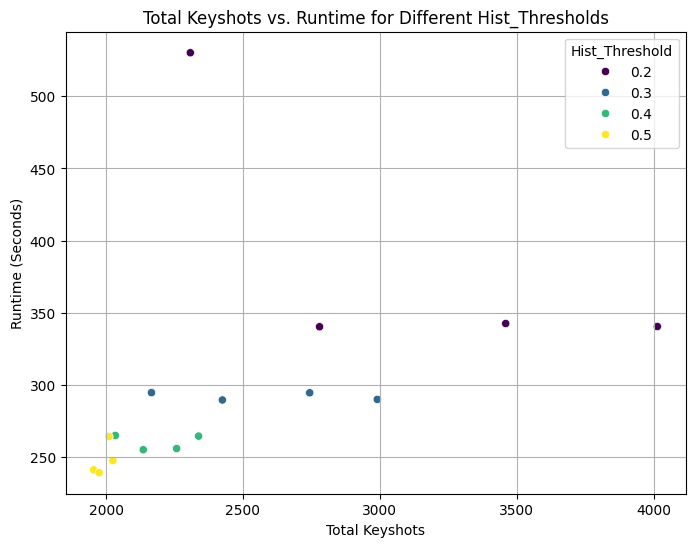

/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Use

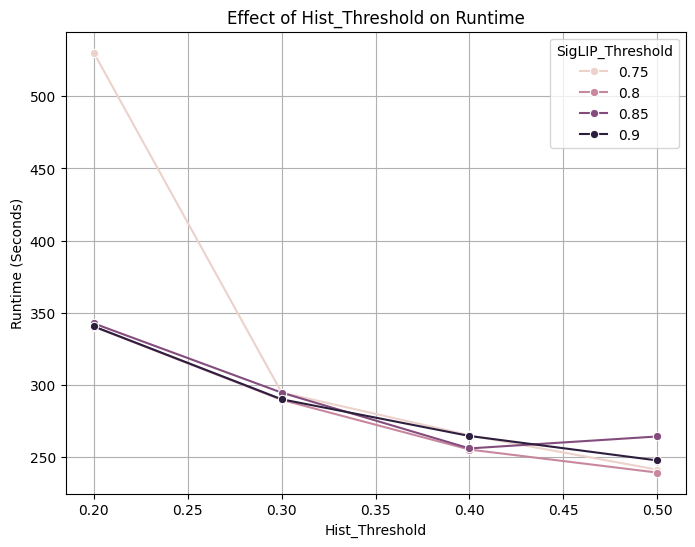

/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mario/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Use

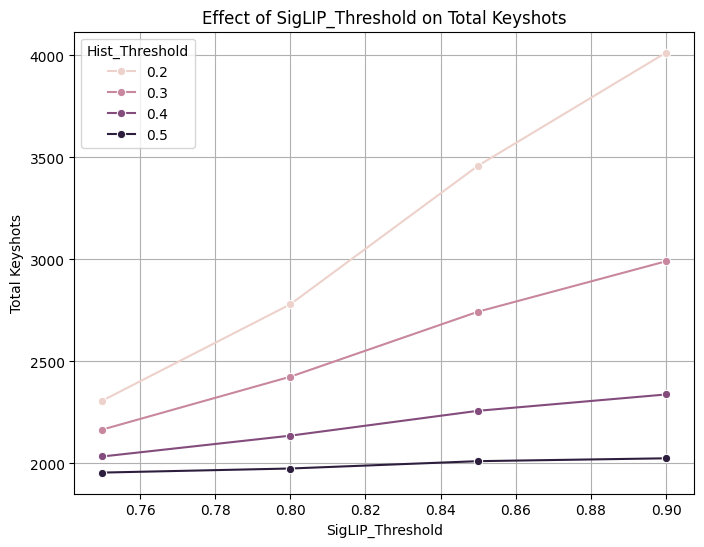

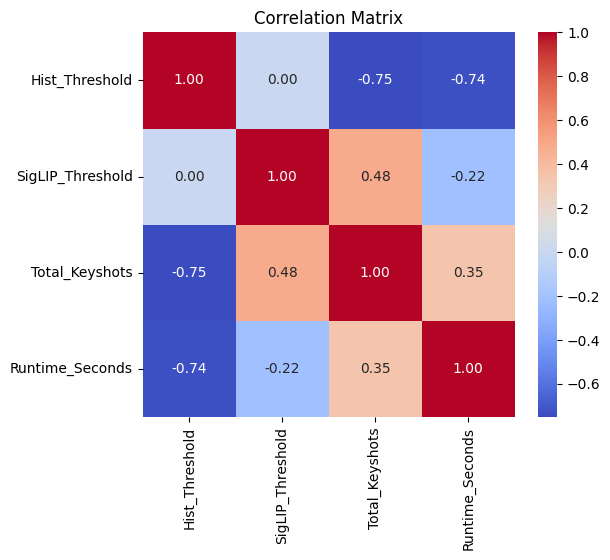


✅ Analysis complete. Results saved to /Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_analysis_results.csv


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load the threshold results from your CSV file
threshold_results_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_results.csv"
threshold_df = pd.read_csv(threshold_results_path)

# 📊 1. Plot Total Keyshots vs. Runtime
plt.figure(figsize=(8, 6))
sns.scatterplot(x=threshold_df["Total_Keyshots"], y=threshold_df["Runtime_Seconds"], hue=threshold_df["Hist_Threshold"], palette="viridis")
plt.title("Total Keyshots vs. Runtime for Different Hist_Thresholds")
plt.xlabel("Total Keyshots")
plt.ylabel("Runtime (Seconds)")
plt.legend(title="Hist_Threshold")
plt.grid(True)
plt.show()

# 📊 2. Analyze Impact of Hist_Threshold on Runtime
plt.figure(figsize=(8, 6))
sns.lineplot(data=threshold_df, x="Hist_Threshold", y="Runtime_Seconds", hue="SigLIP_Threshold", marker="o")
plt.title("Effect of Hist_Threshold on Runtime")
plt.xlabel("Hist_Threshold")
plt.ylabel("Runtime (Seconds)")
plt.grid(True)
plt.show()

# 📊 3. Analyze Impact of SigLIP_Threshold on Total Keyshots
plt.figure(figsize=(8, 6))
sns.lineplot(data=threshold_df, x="SigLIP_Threshold", y="Total_Keyshots", hue="Hist_Threshold", marker="o")
plt.title("Effect of SigLIP_Threshold on Total Keyshots")
plt.xlabel("SigLIP_Threshold")
plt.ylabel("Total Keyshots")
plt.grid(True)
plt.show()

# 📊 4. Correlation Analysis
corr_matrix = threshold_df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# ✅ Save processed results
output_csv_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_analysis_results.csv"
threshold_df.to_csv(output_csv_path, index=False)
print(f"\n✅ Analysis complete. Results saved to {output_csv_path}")


📊 Statistical summary saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_stats_summary.csv

🔍 Best Threshold for Minimum Runtime:
Hist_Threshold         0.5
SigLIP_Threshold       0.8
Total_Keyshots      1975.0
Runtime_Seconds      239.3
Name: 13, dtype: float64

🔍 Best Threshold for Maximum Keyshots:
Hist_Threshold         0.20
SigLIP_Threshold       0.90
Total_Keyshots      4014.00
Runtime_Seconds      340.55
Name: 3, dtype: float64


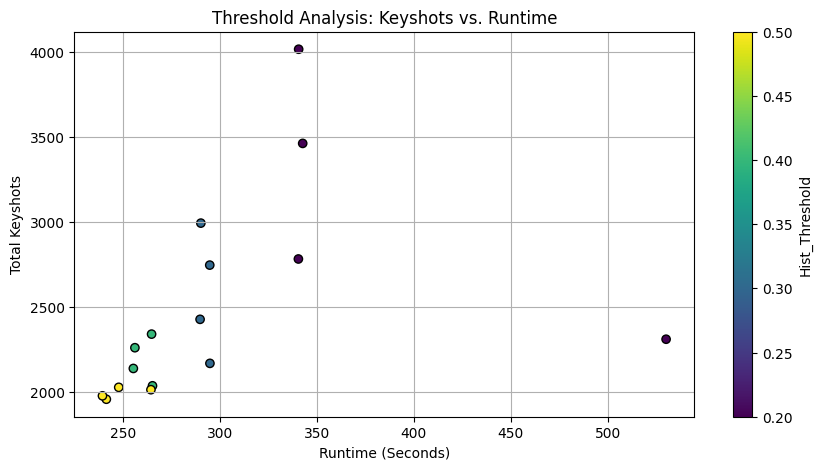


✅ Plot saved at: /Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_analysis_plot.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define file path
RESULTS_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_analysis_results.csv"

# ✅ Load the results CSV
df_results = pd.read_csv(RESULTS_CSV)

# ✅ Generate descriptive statistics
stats_summary = df_results.describe()

# ✅ Save statistical summary
STATS_CSV = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_stats_summary.csv"
stats_summary.to_csv(STATS_CSV, index=True)
print(f"\n📊 Statistical summary saved at: {STATS_CSV}")

# ✅ Find best thresholds based on minimum runtime and maximum keyshots
best_runtime = df_results.loc[df_results["Runtime_Seconds"].idxmin()]
best_keyshots = df_results.loc[df_results["Total_Keyshots"].idxmax()]

print("\n🔍 Best Threshold for Minimum Runtime:")
print(best_runtime)

print("\n🔍 Best Threshold for Maximum Keyshots:")
print(best_keyshots)

# ✅ Visualization: Keyshots vs. Runtime
plt.figure(figsize=(10, 5))
plt.scatter(df_results["Runtime_Seconds"], df_results["Total_Keyshots"], c=df_results["Hist_Threshold"], cmap="viridis", edgecolors="black")
plt.colorbar(label="Hist_Threshold")
plt.xlabel("Runtime (Seconds)")
plt.ylabel("Total Keyshots")
plt.title("Threshold Analysis: Keyshots vs. Runtime")
plt.grid(True)
PLOT_PATH = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_analysis_plot.png"
plt.savefig(PLOT_PATH)
plt.show()

print(f"\n✅ Plot saved at: {PLOT_PATH}")

In [18]:
import pandas as pd
import json

# Load the datasets
threshold_stats_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_stats_summary.csv"
ground_truth_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/wild_bunch_2.csv"
timestamps_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/WildBunch_timestamps.json"

# Load Threshold Analysis Results
df_threshold = pd.read_csv(threshold_stats_path)

# Load Ground Truth
df_ground_truth = pd.read_csv(ground_truth_path)

# Load JSON file (previous results)
with open(timestamps_path, "r") as file:
    json_data = json.load(file)

df_old_results = pd.DataFrame(json_data["sequences"])

# Print Column Names for Debugging
print("\n🔍 Threshold Stats Columns:", df_threshold.columns)
print("\n🔍 Ground Truth Columns:", df_ground_truth.columns)

# Convert JSON timestamps to seconds
df_old_results["start_time"] = df_old_results["start_time"].str.replace(" sec", "").astype(float)
df_old_results["end_time"] = df_old_results["end_time"].str.replace(" sec", "").astype(float)

# Convert ground truth timestamps to numeric
df_ground_truth["Start"] = pd.to_timedelta(df_ground_truth["Start"]).dt.total_seconds()
df_ground_truth["End"] = pd.to_timedelta(df_ground_truth["End"]).dt.total_seconds()

# If 'Total_Keyshots' is missing, estimate based on timestamps
if "Total_Keyshots" not in df_ground_truth.columns:
    print("\n⚠️ 'Total_Keyshots' not found in ground truth. Estimating based on timestamps...")

    # Count the number of shots in each time range
    df_ground_truth["Total_Keyshots"] = df_ground_truth.apply(
        lambda row: ((df_old_results["start_time"] >= row["Start"]) & (df_old_results["end_time"] <= row["End"])).sum(),
        axis=1
    )

# If 'Runtime_Seconds' is missing in ground truth, calculate it
if "Runtime_Seconds" not in df_ground_truth.columns:
    print("\n⚠️ 'Runtime_Seconds' not found in ground truth. Estimating as (End - Start)...")
    df_ground_truth["Runtime_Seconds"] = df_ground_truth["End"] - df_ground_truth["Start"]

# Compute Error Metrics
df_threshold["Error_Keyshots"] = (df_threshold["Total_Keyshots"] - df_ground_truth["Total_Keyshots"]).abs()
df_threshold["Error_Runtime"] = (df_threshold["Runtime_Seconds"] - df_ground_truth["Runtime_Seconds"]).abs()

# Generate Descriptive Statistics
stats_summary = df_threshold.describe()

# Identify Best Threshold (Lowest Error)
best_threshold = df_threshold.loc[df_threshold["Error_Keyshots"].idxmin()]

# Save the comparison results
comparison_csv_path = "/Users/mario/Desktop/ece910/Wild-Bunch-output/threshold_comparison_results.csv"
stats_summary.to_csv(comparison_csv_path, index=True)

# Print insights
print("\n🔍 Statistical Summary:")
print(stats_summary)

print("\n🏆 Best Threshold Settings:")
print(best_threshold)

print(f"\n✅ Comparison results saved at: {comparison_csv_path}")


🔍 Threshold Stats Columns: Index(['Unnamed: 0', 'Hist_Threshold', 'SigLIP_Threshold', 'Total_Keyshots',
       'Runtime_Seconds'],
      dtype='object')

🔍 Ground Truth Columns: Index(['Start', 'End', 'Action'], dtype='object')

⚠️ 'Total_Keyshots' not found in ground truth. Estimating based on timestamps...

⚠️ 'Runtime_Seconds' not found in ground truth. Estimating as (End - Start)...

🔍 Statistical Summary:
       Hist_Threshold  SigLIP_Threshold  Total_Keyshots  Runtime_Seconds  \
count        8.000000          8.000000        8.000000         8.000000   
mean         2.276934          2.625967     2014.791542       249.154678   
std          5.546288          5.410777     1245.427641       156.549160   
min          0.115470          0.057735       16.000000        16.000000   
25%          0.256250          0.778125     1613.583084       197.241699   
50%          0.350000          0.825000     2157.375000       266.620000   
75%          0.443750          0.871875     2545.4375